In [1]:
#import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten,Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tqdm.notebook import tqdm_notebook as tqdm

import os

In [2]:
print(os.listdir("C:/Users/yuvas/Pictures/yuvadataset"))

['images', 'working']


In [3]:
Tuberculosis= 'C:/Users/yuvas/Pictures/yuvadataset/images/Tuberculosis/'
Normal= 'C:/Users/yuvas/Pictures/yuvadataset/images/Normal/'
covid = 'C:/Users/yuvas/Pictures/yuvadataset/images/covid/'
pneumonia = 'C:/Users/yuvas/Pictures/yuvadataset/images/pneumonia/'

Tuberculosis_path = os.listdir(Tuberculosis)
Normal_path = os.listdir(Normal)
covid_path = os.listdir(covid)
pneumonia_path = os.listdir(pneumonia)

In [4]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1] #bgr to rgb

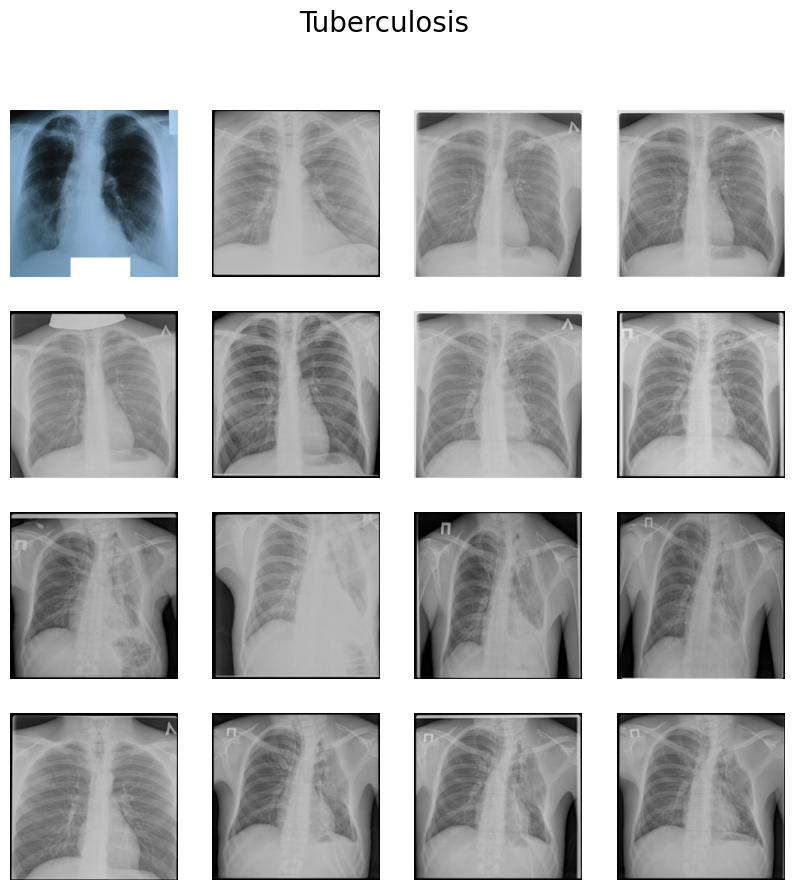

In [5]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(Tuberculosis + Tuberculosis_path[i]), cmap='gray')
    plt.suptitle("Tuberculosis",fontsize=20)
    plt.axis('off')

plt.show()

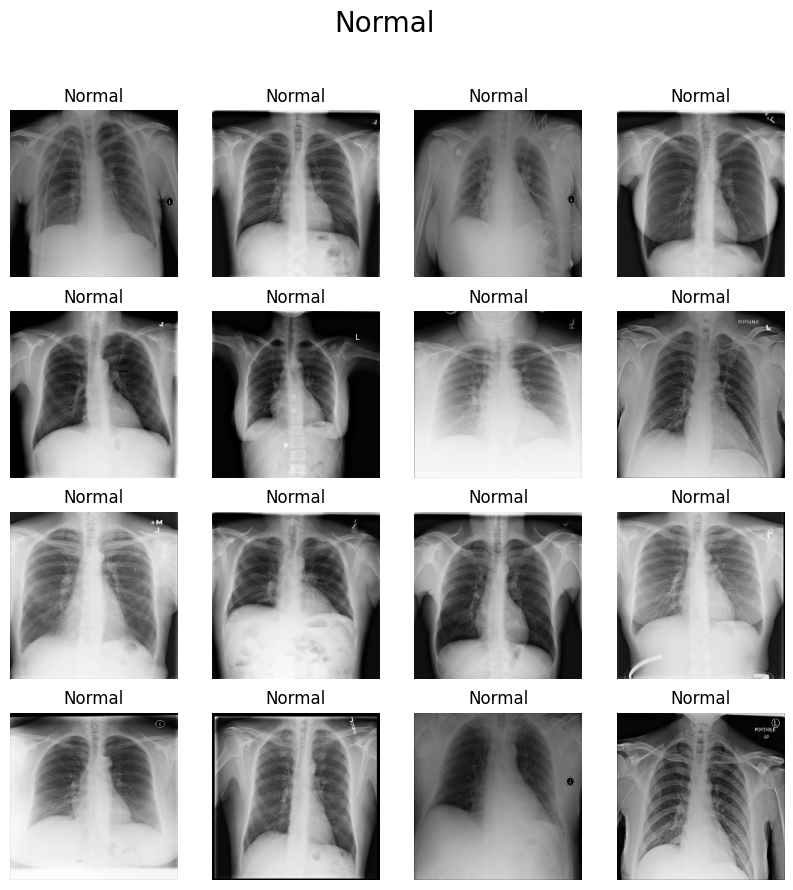

In [6]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(Normal + Normal_path[i]), cmap='gray')
    plt.suptitle("Normal",fontsize=20)
    plt.title(Normal_path[i][:6])
    plt.axis('off')

plt.show()



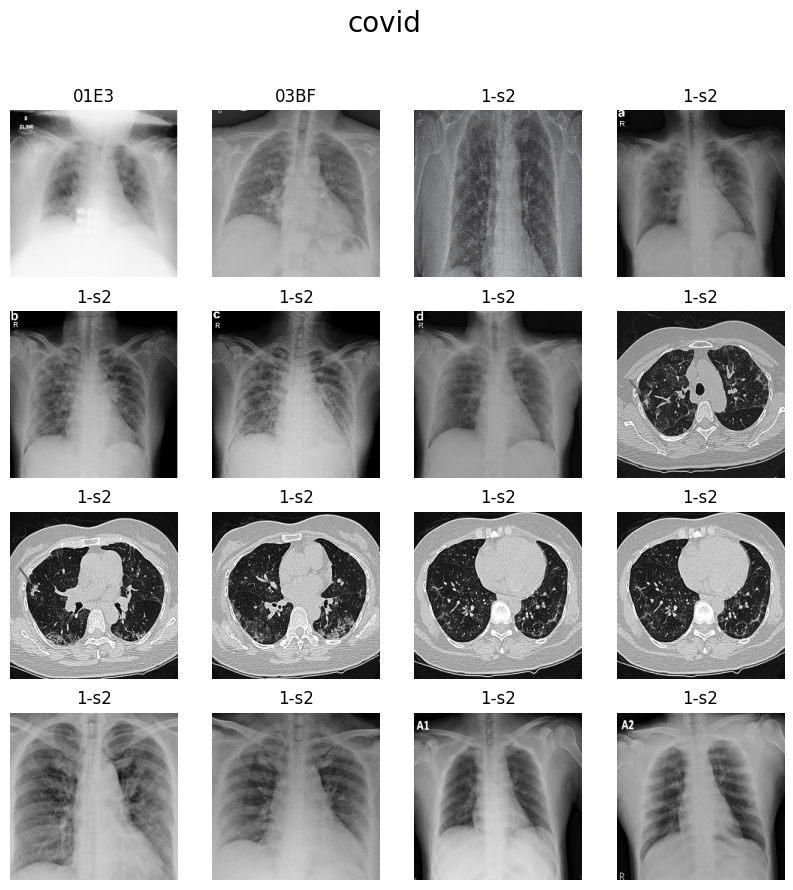

In [7]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(covid + covid_path[i]), cmap='gray')
    plt.suptitle("covid",fontsize=20)
    plt.title(covid_path[i][:4])
    plt.axis('off')

plt.show()

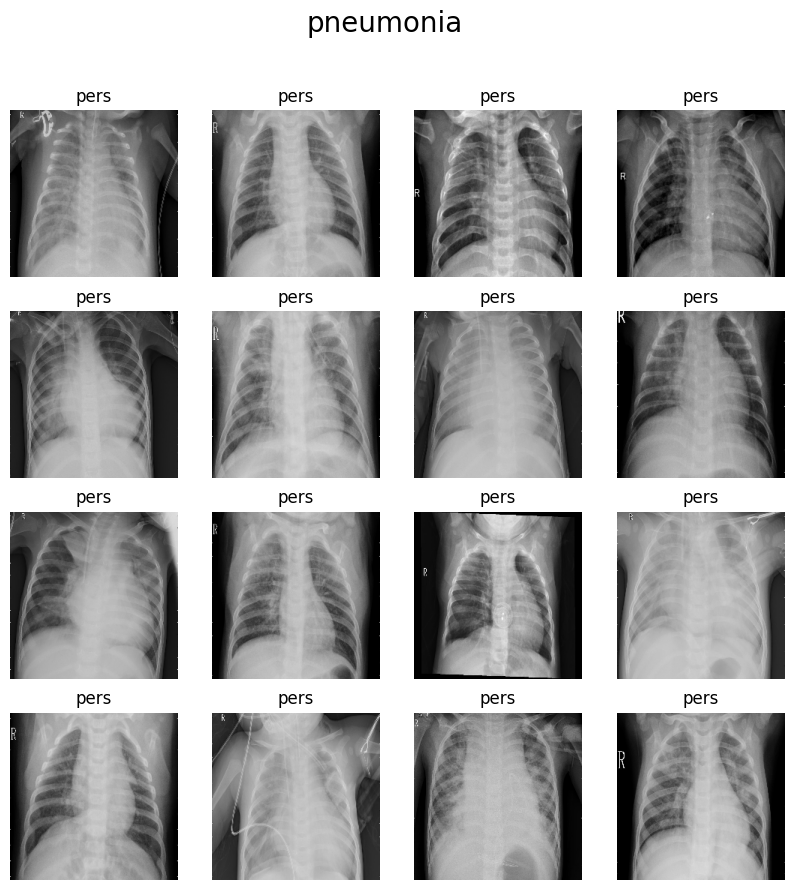

In [8]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(pneumonia + pneumonia_path[i]), cmap='gray')
    plt.suptitle("pneumonia",fontsize=20)
    plt.title(pneumonia_path[i][:4])
    plt.axis('off')

plt.show()

In [9]:
dataset_path = "C:/Users/yuvas/Pictures/yuvadataset/images/"

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                     
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [12]:
train_dataset  = train_datagen.flow_from_directory(directory = 'C:/Users/yuvas/Pictures/yuvadataset/working/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 9281 images belonging to 4 classes.


In [13]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'C:/Users/yuvas/Pictures/yuvadataset/working/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 2318 images belonging to 4 classes.


In [14]:
test_dataset = test_datagen.flow_from_directory(directory = 'C:/Users/yuvas/Pictures/yuvadataset/working/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 2696 images belonging to 4 classes.


In [15]:
import efficientnet.keras as efn
base_model = efn.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling=None,
    classes=4)

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
# Building Model

x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(32,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(4,activation='softmax')(x)

model1 = Model(inputs=base_model.inputs, outputs=predictions)

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                             

 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 144)  0          ['block2b_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_s

 block4b_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (FixedDropout)    (None, 14, 14, 80)   0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_a

 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, 7, 7, 672)   16800       ['block6a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 7, 7, 672)   2688        ['block6a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_s

 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block7a_activation[0][0]',     
          

In [18]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling=None,
    classes=4)
for layer in base_model.layers:
    layer.trainable = False

# Building Model

x = base_model.output
x = Dropout(0.5)(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(32,kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(4,activation='softmax')(x)

model2 = Model(inputs=base_model.inputs, outputs=predictions)

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

__________________________________________________________________________________________________


In [19]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
]
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

model_filepath = "C:/Users/yuvas/models/{epoch:02d}-{val_accuracy:.4f}.hdf5"
mcp = ModelCheckpoint(
 filepath=model_filepath,
 monitor='val_accuracy',
 mode='max',
 save_best_only=True,
 verbose=1
)

es = EarlyStopping(verbose=1, patience=20)

model1.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)


In [20]:
history1=model1.fit(train_dataset,validation_data=valid_dataset,epochs = 20 ,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/20
146/146 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.9449 - precision: 0.9185 - recall: 0.8554
Epoch 1: val_accuracy improved from -inf to 0.91534, saving model to C:/Users/yuvas/models\01-0.9153.hdf5
146/146 [==============================] - 827s 6s/step - loss: 0.3324 - accuracy: 0.9449 - precision: 0.9185 - recall: 0.8554 - val_loss: 0.5538 - val_accuracy: 0.9153 - val_precision: 0.8433 - val_recall: 0.8123 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9641 - precision: 0.9404 - recall: 0.9146
Epoch 2: val_accuracy improved from 0.91534 to 0.91836, saving model to C:/Users/yuvas/models\02-0.9184.hdf5
146/146 [==============================] - 717s 5s/step - loss: 0.2095 - accuracy: 0.9641 - precision: 0.9404 - recall: 0.9146 - val_loss: 0.4588 - val_accuracy: 0.9184 - val_precision: 0.8455 - val_recall: 0.8240 - lr: 0.0010
Epoch 3/20
146/146 [==============================] - ETA: 0s - l

Epoch 20/20
146/146 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9803 - precision: 0.9631 - recall: 0.9578
Epoch 20: val_accuracy improved from 0.95093 to 0.95104, saving model to C:/Users/yuvas/models\20-0.9510.hdf5
146/146 [==============================] - 512s 4s/step - loss: 0.1085 - accuracy: 0.9803 - precision: 0.9631 - recall: 0.9578 - val_loss: 0.2788 - val_accuracy: 0.9510 - val_precision: 0.9070 - val_recall: 0.8960 - lr: 0.0010


In [21]:
model_filepath = "C:/Users/yuvas/model_mobilenet/{epoch:02d}-{val_accuracy:.4f}.hdf5"
mcp = ModelCheckpoint(
 filepath=model_filepath,
 monitor='val_accuracy',
 mode='max',
 save_best_only=True,
 verbose=1
)
model2.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [22]:
history2=model2.fit(train_dataset,validation_data=valid_dataset,epochs = 20 ,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/20
146/146 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9590 - precision: 0.9373 - recall: 0.8959
Epoch 1: val_accuracy improved from -inf to 0.91512, saving model to C:/Users/yuvas/model_mobilenet\01-0.9151.hdf5
146/146 [==============================] - 555s 4s/step - loss: 0.2546 - accuracy: 0.9590 - precision: 0.9373 - recall: 0.8959 - val_loss: 0.6021 - val_accuracy: 0.9151 - val_precision: 0.8440 - val_recall: 0.8102 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9759 - precision: 0.9594 - recall: 0.9436
Epoch 2: val_accuracy improved from 0.91512 to 0.92504, saving model to C:/Users/yuvas/model_mobilenet\02-0.9250.hdf5
146/146 [==============================] - 563s 4s/step - loss: 0.1504 - accuracy: 0.9759 - precision: 0.9594 - recall: 0.9436 - val_loss: 0.4946 - val_accuracy: 0.9250 - val_precision: 0.8644 - val_recall: 0.8305 - lr: 0.0010
Epoch 3/20
146/146 [===========================

146/146 [==============================] - 429s 3s/step - loss: 0.0724 - accuracy: 0.9870 - precision: 0.9754 - recall: 0.9724 - val_loss: 0.5149 - val_accuracy: 0.9275 - val_precision: 0.8606 - val_recall: 0.8473 - lr: 0.0010
Epoch 20/20
146/146 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9877 - precision: 0.9772 - recall: 0.9735
Epoch 20: val_accuracy did not improve from 0.94316
146/146 [==============================] - 511s 3s/step - loss: 0.0696 - accuracy: 0.9877 - precision: 0.9772 - recall: 0.9735 - val_loss: 0.3964 - val_accuracy: 0.9419 - val_precision: 0.8889 - val_recall: 0.8770 - lr: 0.0010


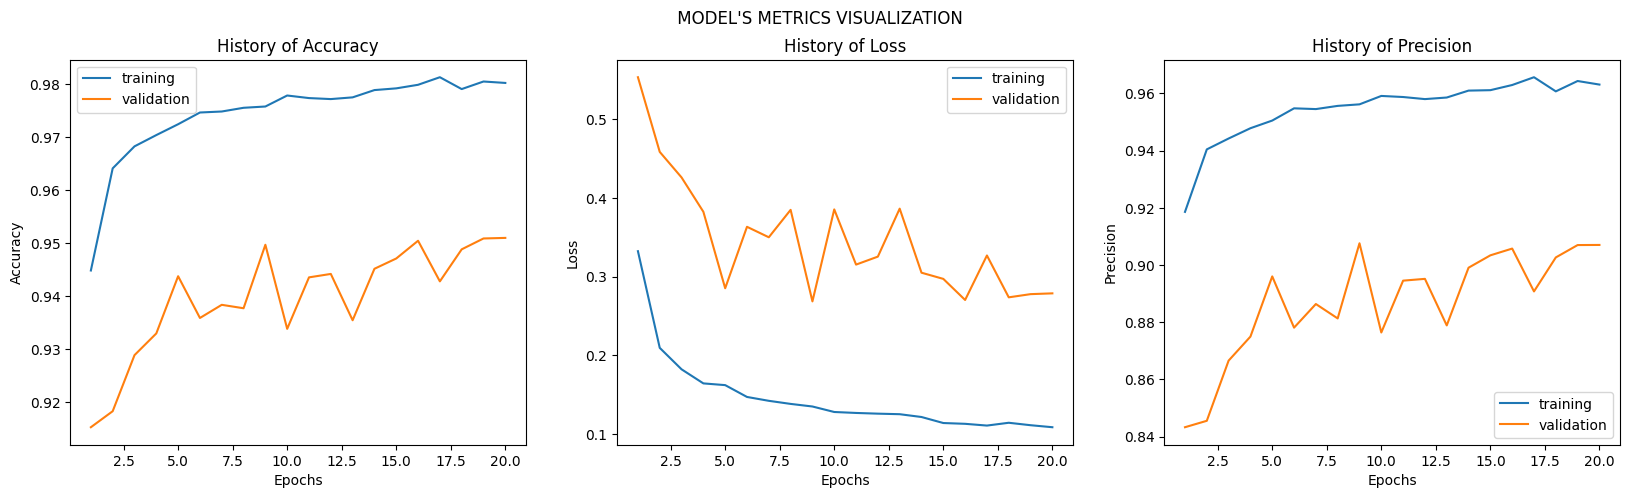

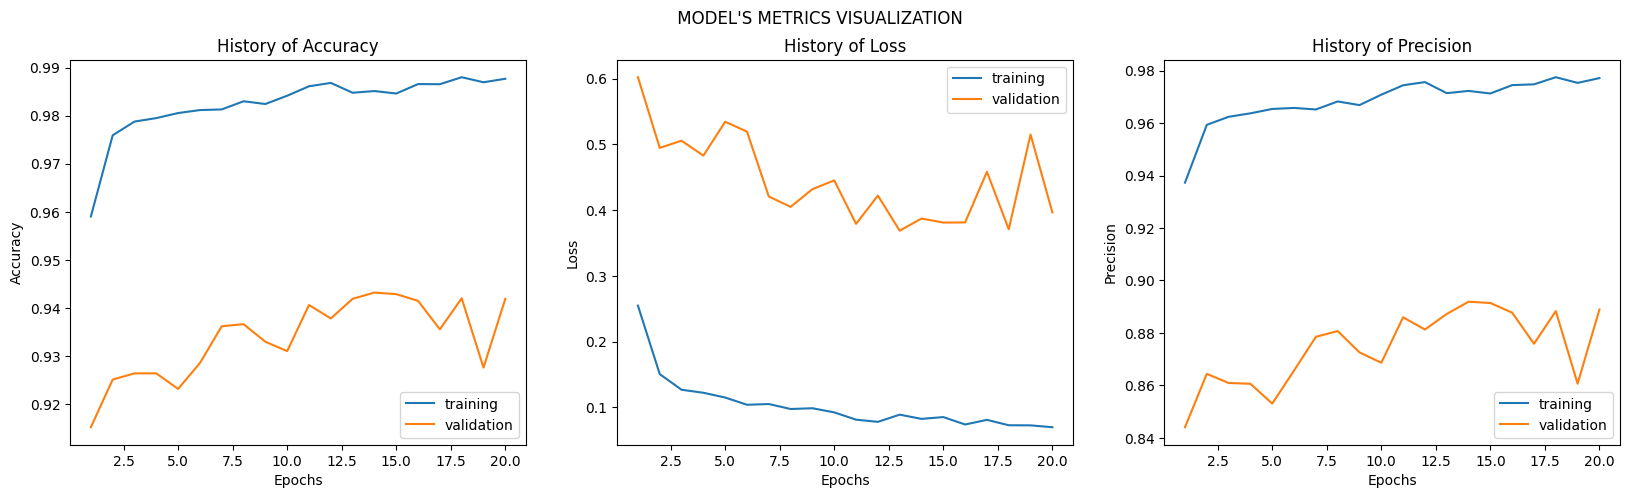

In [23]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,precision,val_precision):
    
    fig, (ax1, ax2,ax4) = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history1.history['accuracy'],history1.history['val_accuracy'],
               history1.history['loss'],history1.history['val_loss'],
               history1.history['precision'],history1.history['val_precision']
#                history.history['f1_score'],history.history['val_f1_score']
              )
Train_Val_Plot(history2.history['accuracy'],history2.history['val_accuracy'],
               history2.history['loss'],history2.history['val_loss'],
               history2.history['precision'],history2.history['val_precision']
#                history.history['f1_score'],history.history['val_f1_score']
              )


In [24]:
prediction1 = model1.evaluate(test_dataset)

43/43 [==============================] - 165s 4s/step - loss: 0.2686 - accuracy: 0.9522 - precision: 0.9095 - recall: 0.8984


In [25]:
prediction2 = model2.evaluate(test_dataset)

43/43 [==============================] - 90s 2s/step - loss: 0.4268 - accuracy: 0.9369 - precision: 0.8784 - recall: 0.8680


In [27]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Load the pre-trained model1
model1 = load_model("C:/Users/yuvas/models/20-0.9510.hdf5")


# Evaluate the model on the test data
loss, accuracy,precision,recall = model1.evaluate(test_dataset)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:",precision)
print("Test Recall:",recall)



# Predict on the test data
predictions = model1.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)


# Print the predicted classes
print("Predicted Classes:", predicted_classes)

43/43 [==============================] - 947s 21s/step - loss: 0.2686 - accuracy: 0.9522 - precision: 0.9095 - recall: 0.8984
Test Loss: 0.2686363756656647
Test Accuracy: 0.9522440433502197
Test Precision: 0.9095005393028259
Test Recall: 0.8983679413795471
43/43 [==============================] - 960s 21s/step
Predicted Classes: tf.Tensor([2 2 3 ... 3 0 3], shape=(2696,), dtype=int64)


In [28]:
# Load the pre-trained model2
model2 = load_model("C:/Users/yuvas/model_mobilenet/14-0.9432.hdf5")


# Evaluate the model on the test data
loss, accuracy,precision,recall = model2.evaluate(test_dataset)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:",precision)
print("Test Recall:",recall)



# Predict on the test data
predictions = model2.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)


# Print the predicted classes
print("Predicted Classes:", predicted_classes)

43/43 [==============================] - 623s 14s/step - loss: 0.4258 - accuracy: 0.9362 - precision: 0.8789 - recall: 0.8639
Test Loss: 0.42582789063453674
Test Accuracy: 0.9362017512321472
Test Precision: 0.8788679242134094
Test Recall: 0.8638724088668823
43/43 [==============================] - 125s 2s/step
Predicted Classes: tf.Tensor([0 2 0 ... 3 0 1], shape=(2696,), dtype=int64)


In [29]:
predicted_values = tf.argmax(predictions, axis=1)
category_names = ["Tuberculosis", "Normal", "covid","pneumonia"]
predicted_categories = [category_names[value] for value in predicted_values]
# Initial
print(predicted_categories[:6])

['Tuberculosis', 'covid', 'Tuberculosis', 'Tuberculosis', 'Tuberculosis', 'covid']


In [54]:
# Load and preprocess the image
image_path = "C:/Users/yuvas/Pictures/yuvadataset/images/Tuberculosis/Tuberculosis-479.png"
image = load_img(image_path)
image_array = img_to_array(image)
image_preprocessed = preprocess_input(image_array)

# Expand dimensions to create a batch of size 1
image_batch = np.expand_dims(image_preprocessed, axis=0)



# Make predictions
predictions = model1.predict(image_batch)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map class index to class label using the class_labels dictionary
class_labels = {0: 'Normal', 1: 'Tuberculosis', 2: 'covid', 3: 'pneumonia'}
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class label:", predicted_class_label)


1/1 [==============================] - 0s 140ms/step
Predicted class label: Tuberculosis


In [37]:
# Load and preprocess the image
image_path = "C:/Users/yuvas/Pictures/yuvadataset/images/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1b.png"
image = load_img(image_path)
image_array = img_to_array(image)
image_preprocessed = preprocess_input(image_array)

# Expand dimensions to create a batch of size 1
image_batch = np.expand_dims(image_preprocessed, axis=0)



# Make predictions
predictions = model2.predict(image_batch)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map class index to class label using the class_labels dictionary
class_labels = {0: 'Tuberculosis', 1: 'Normal', 2: 'covid', 3: 'pneumonia'}
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class label:", predicted_class_label)


1/1 [==============================] - 0s 102ms/step
Predicted class label: covid


In [38]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model1 = load_model("C:/Users/yuvas/models/20-0.9510.hdf5")
model1 = Model(inputs=model1.inputs,
                outputs=model1.outputs,
                name='name_of_model_1')
model2 = load_model("C:/Users/yuvas/model_mobilenet/14-0.9432.hdf5")
model2 = Model(inputs=model2.inputs,
                outputs=model2.outputs,
                name='name_of_model_2')
models = [model1, model2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [39]:

model_filepath = "C:/Users/yuvas/ensemble_model/{epoch:02d}-{val_accuracy:.4f}.hdf5"
mcp = ModelCheckpoint(
 filepath=model_filepath,
 monitor='val_accuracy',
 mode='max',
 save_best_only=True,
 verbose=1
)

es = EarlyStopping(verbose=1, patience=20)
ensemble_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [40]:
history3=ensemble_model.fit(train_dataset,validation_data=valid_dataset,epochs = 20 ,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/20
146/146 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9770 - precision: 0.9571 - recall: 0.9504
Epoch 1: val_accuracy improved from -inf to 0.93928, saving model to C:/Users/yuvas/ensemble_model\01-0.9393.hdf5
146/146 [==============================] - 861s 6s/step - loss: 0.0798 - accuracy: 0.9770 - precision: 0.9571 - recall: 0.9504 - val_loss: 0.3835 - val_accuracy: 0.9393 - val_precision: 0.8884 - val_recall: 0.8658 - lr: 0.0010
Epoch 2/20
146/146 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9892 - precision: 0.9812 - recall: 0.9754 
Epoch 2: val_accuracy improved from 0.93928 to 0.95772, saving model to C:/Users/yuvas/ensemble_model\02-0.9577.hdf5
146/146 [==============================] - 3968s 27s/step - loss: 0.0759 - accuracy: 0.9892 - precision: 0.9812 - recall: 0.9754 - val_loss: 0.2456 - val_accuracy: 0.9577 - val_precision: 0.9231 - val_recall: 0.9064 - lr: 0.0010
Epoch 3/20
146/146 [==========================

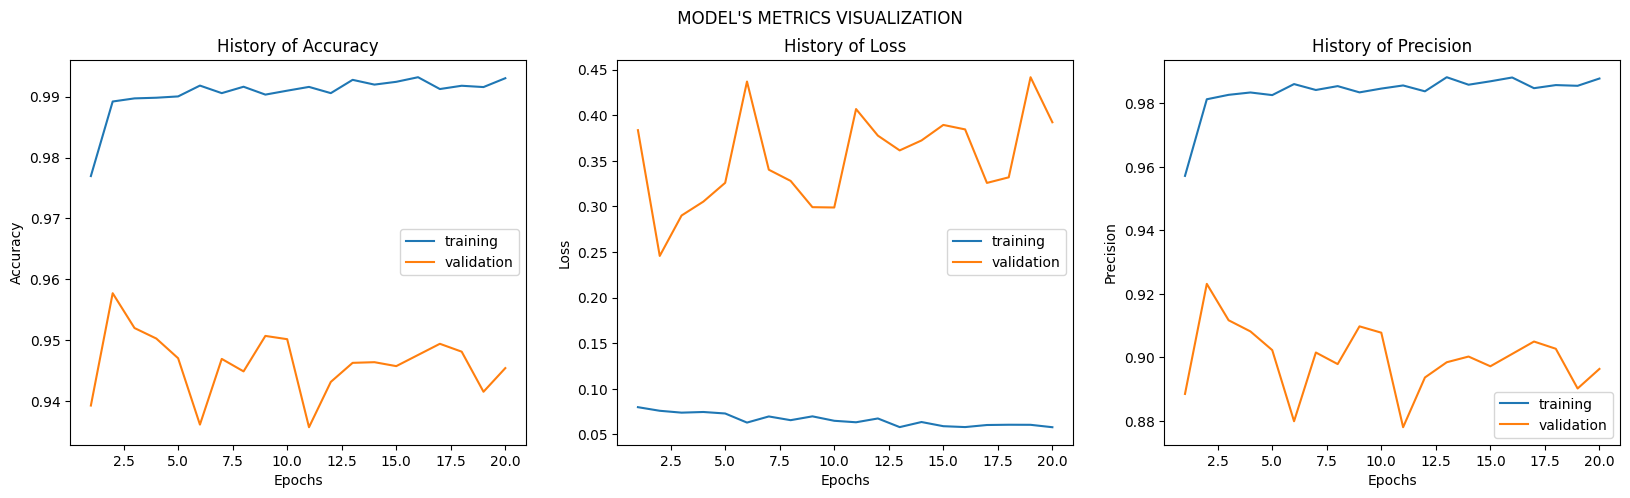

In [41]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,precision,val_precision):
    
    fig, (ax1, ax2,ax4) = plt.subplots(1,3, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history3.history['accuracy'],history3.history['val_accuracy'],
               history3.history['loss'],history3.history['val_loss'],
               history3.history['precision'],history3.history['val_precision']
#                history.history['f1_score'],history.history['val_f1_score']
              )

In [42]:
prediction3 = ensemble_model.evaluate(test_dataset)

43/43 [==============================] - 274s 6s/step - loss: 0.3816 - accuracy: 0.9444 - precision: 0.8958 - recall: 0.8798


In [44]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Load the pre-trained model
ensemble_model = load_model("C:/Users/yuvas/ensemble_model/02-0.9577.hdf5")


# Evaluate the model on the test data
loss, accuracy,precision,recall = ensemble_model.evaluate(test_dataset)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:",precision)
print("Test Recall:",recall)



# Predict on the test data
predictions = ensemble_model.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)


# Print the predicted classes
print("Predicted Classes:", predicted_classes)

43/43 [==============================] - 235s 5s/step - loss: 0.2420 - accuracy: 0.9585 - precision: 0.9261 - recall: 0.9065
Test Loss: 0.2419750988483429
Test Accuracy: 0.9585496783256531
Test Precision: 0.9261083602905273
Test Recall: 0.9065281748771667
43/43 [==============================] - 234s 5s/step
Predicted Classes: tf.Tensor([3 0 2 ... 0 0 3], shape=(2696,), dtype=int64)


In [48]:
# Load and preprocess the image
image_path = "C:/Users/yuvas/Pictures/yuvadataset/images/pneumonia/person64_bacteria_312.jpeg"

image = load_img(image_path)
image_array = img_to_array(image)
image_preprocessed = preprocess_input(image_array)

# Expand dimensions to create a batch of size 1
image_batch = np.expand_dims(image_preprocessed, axis=0)



# Make predictions
predictions = ensemble_model.predict(image_batch)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map class index to class label using the class_labels dictionary
class_labels = {0: 'Tuberculosis', 1: 'Normal', 2: 'covid', 3: 'pneumonia'}
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class label:", predicted_class_label)

1/1 [==============================] - 0s 147ms/step
Predicted class label: pneumonia
